In [ ]:
# ============================================================================
## Multi-Task DNN-QSAR Models for simultaneous prediction of Eye Irritation, Skin Irritation, and Skin Sensitization toxicity
# Author: Alexa Canchola, Kunpeng Chen
# Advisor: Wei-Chun Chou
# Date: July 14, 2025
# ==============================================================================
"""
This script builds and evaluates a multi-task deep neural network QSAR (DNN-QSAR) model for the simultaneous prediction of:
 - Eye Irritation
 - Skin Irritation
 - Skin Sensitization

The model is developed for organic compounds associated with e-cigarettes.
"""

In [ ]:
# ============================================================================
# Install Required Dependencies
# ============================================================================
!pip install -q rdkit shap scikit-optimize torch torchvision -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.

In [ ]:
# ============================================================================
# Import Required Libraries
# ============================================================================
# Standard Libraries for Data Handling  & Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random, warnings, time
from rdkit import RDLogger

# PyTorch Libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Scikit-learn (sklearn): Model Selection & Evaluation  performance
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (accuracy_score, roc_auc_score, balanced_accuracy_score, roc_curve, auc, confusion_matrix,
                             matthews_corrcoef, precision_score, recall_score, f1_score)
from sklearn.exceptions import UndefinedMetricWarning

# Bayesian Optimization (for hyperparameter tuning)
from skopt import gp_minimize

# RDKit: Molecular Fingerprint & Descriptor Calculations
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys, RDKFingerprint, Descriptors
from rdkit.Chem.AllChem import GetMorganGenerator
from rdkit.DataStructs import ConvertToNumpyArray
from rdkit.ML.Descriptors import MoleculeDescriptors

# Feature Scaling for RDKit Descriptors
from sklearn.preprocessing import MinMaxScaler

# Applicaibility Domain Calculation
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

#Feature Importance analysis
import shap

#For usage in Google Colab
from google.colab import files
import io

import joblib
import os

In [ ]:
# ============================================================================
# Filter Extraneous Warnings
# ============================================================================
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=UndefinedMetricWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# Disable ALL RDKit logs
RDLogger.DisableLog('rdApp.*')

In [ ]:
# %% ============================================================================
# Import Data
# ============================================================================
# Read raw data in Python IDE other than Google Colab
# dataset_raw = pd.read_csv('Data_corrected.csv') # Replace with the correct path if needed

# Load Data in Google Colab
ecig = files.upload() # Data_corrected.csv
ecig_file = list(ecig.keys())[0]
dataset_raw = pd.read_csv(io.BytesIO(ecig[ecig_file]))

Saving Data_corrected(1).csv to Data_corrected(1).csv


In [ ]:
# ============================================================================
# Preprocess Data
# ============================================================================
column_names = ['Chemicals',
                'CAS',
                'SMILES',
                'Cancer',
                'Genotoxicity',
                'Skin',
                'Eye',
                'Skin (Irritating)',
                'Skin (sensitizing)']

remove_elements = [[],
                   [],
                   [],
                   [],
                   [],
                   [],
                   [],
                   [],
                   []]

# Define Function for Data Cleaning
def RemoveElements(df, column_names, remove_elements):
    for i in range(0,len(column_names)):
        for j in range(0,len(remove_elements[i])):
            df = df[df[column_names[i]] != remove_elements[i][j]]

    return df

data = RemoveElements(dataset_raw, column_names, remove_elements)

#Check Data
print('Total number of data points: ' + str(len(data.index)))
print('--------------------------------------------------------------')
print(data.head())

Total number of data points: 966
--------------------------------------------------------------
                      Chemical_Names        CAS                       SMILES  \
0                     Benzyl acetate   140-11-4          CC(=O)OCC1=CC=CC=C1   
1                       Benzophenone   119-61-9  O=C(C1=CC=CC=C1)C1=CC=CC=C1   
2                            Acetoin   513-86-0                  CC(O)C(C)=O   
3                       alpha-Ionone   127-41-3  CC(=O)\C=C\C1C(C)=CCCC1(C)C   
4  1,3-Dioxolane, 4-methyl-2-pentyl-  1599-49-1              CCCCCC1OCC(C)O1   

  Cancer Genotoxicity Skin Eye Skin (Irritating) Skin (sensitizing)  
0      0            1    1   1                 1                  0  
1      1            1    0   1                 1                  0  
2     na            1    1   1                 1                 na  
3     na            1    0   0                 0                  0  
4     na           na   na  na                na                 na  


In [ ]:
# ============================================================================
#  Check Task Dsitributions
# ============================================================================
def CheckData(df, column_name):
    item_counts = df[column_name].value_counts()

    print("Item  Count")
    for item, count in item_counts.items():
        print(f"{item}  {count}")


# Check Class Distributions
print('--------------------------------------------------------------')
print('Class Distributions - Eye irritation')
CheckData(data, 'Eye')

print('--------------------------------------------------------------')
print('Class Distributions - Skin irritation')
CheckData(data, 'Skin (Irritating)')

print('--------------------------------------------------------------')
print('Class Distributions - Skin sensitization')
CheckData(data, 'Skin (sensitizing)')

Item  Count
na  611
1  253
0  102
Item  Count
na  583
1  294
0  89
Item  Count
na  672
0  150
1  144
Item  Count
na  859
1  64
0  43
Item  Count
na  514
1  227
0  225


In [ ]:
# ============================================================================
# Functions for Model Evaluation & Metrics
# ============================================================================
def weighted_average(values, weights):
    # Ensure the lengths of roc_auc_each_output and weights are the same
    if len(values) != len(weights):
        raise ValueError("Length of values must be equal to the length of weights")

    weighted_sum = sum(value * weight for value, weight in zip(values, weights))
    total_weight = sum(weights)

    return weighted_sum / total_weight if total_weight != 0 else 0

# Calculate standard classification metrics
def model_metrics(y_true, y_pred, y_pred_prob):

    if (torch.is_tensor(y_true)):
        y_true = y_true.ravel().tolist()
    if (torch.is_tensor(y_pred)):
        y_pred = y_pred.ravel().tolist()
    if (torch.is_tensor(y_pred_prob)):
        y_pred_prob = y_pred_prob.ravel().tolist()

    roc_auc = roc_auc_score(y_true, y_pred_prob)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return [roc_auc, balanced_accuracy, mcc, accuracy, precision, recall, f1]

# Calculate mean and std of cross validation metics
def calculate_cv_avg_std(outer_results):

    # Calculate mean and std of all metrics from outer results
    avg_ncv_auc = np.mean([result["outer_auc"] for result in outer_results])
    avg_ncv_balanced_acc = np.mean([result["outer_balanced_accuracy"] for result in outer_results])
    avg_ncv_mcc = np.mean([result["outer_mcc"] for result in outer_results])
    avg_ncv_accuracy = np.mean([result["outer_accuracy"] for result in outer_results])
    avg_ncv_precision = np.mean([result["outer_precision"] for result in outer_results])
    avg_ncv_recall = np.mean([result["outer_recall"] for result in outer_results])
    avg_ncv_f1 = np.mean([result["outer_f1"] for result in outer_results])

    std_ncv_auc = np.std([result["outer_auc"] for result in outer_results])
    std_ncv_balanced_acc = np.std([result["outer_balanced_accuracy"] for result in outer_results])
    std_ncv_mcc = np.std([result["outer_mcc"] for result in outer_results])
    std_ncv_accuracy = np.std([result["outer_accuracy"] for result in outer_results])
    std_ncv_precision = np.std([result["outer_precision"] for result in outer_results])
    std_ncv_recall = np.std([result["outer_recall"] for result in outer_results])
    std_ncv_f1 = np.std([result["outer_f1"] for result in outer_results])

    # Print the summary of nested cross-validation results
    print('----------------------------------------------------------')
    print("Cross validation (mean ± std):")
    print("AUC, balanced accuracy, MCC, accuracy, precision, recall, F1")

    print(f"{avg_ncv_auc:.3f} ± {std_ncv_auc:.3f}, {avg_ncv_balanced_acc:.3f} ± {std_ncv_balanced_acc:.3f}, {avg_ncv_mcc:.3f} ± {std_ncv_mcc:.3f}, "
          f"{avg_ncv_accuracy:.3f} ± {std_ncv_accuracy:.3f}, {avg_ncv_precision:.3f} ± {std_ncv_precision:.3f}, "
          f"{avg_ncv_recall:.3f} ± {std_ncv_recall:.3f}, {avg_ncv_f1:.3f} ± {std_ncv_f1:.3f}")

    return avg_ncv_auc, avg_ncv_f1, avg_ncv_balanced_acc, avg_ncv_mcc, std_ncv_mcc


In [ ]:
# ============================================================================
# Generate desired fingerprints/molecular descriptors from SMILES
# ============================================================================

def smiles_to_feature(smiles, mode="MACCS", **kwargs):
      """
    Convert SMILES strings into molecular feature representation.

    Parameters
    ----------
    smiles : str
        The SMILES string representing the molecule.
    mode : str, default="MACCS"
        The type of molecular representation to compute. Options are:

        - "MACCS": MACCS structural keys (167-bit fingerprint).

        - "Morgan": Morgan fingerprints Radius=3 and fpsize = 2048

        - "FCFP": Feature-Class Fingerprints (FCFP)

        - "RDK": RDKit topological/path-based fingerprint. fpsize=2048).

        - "Descriptors": A vector of molecular descriptors from RDKit’s
          `Descriptors._descList` (e.g., molecular weight, logP, etc.).

    **kwargs :
        Extra arguments passed depending on `mode`.
        - Morgan/FCFP: `radius` (int), `fpSize` (int), `include_chirality` (bool)
        - RDK: `fpSize` (int)

    Returns
    -------
    np.ndarray
        A NumPy array representing the fingerprint or descriptor vector.
        The size depends on `mode`:
        - MACCS: 167
        - Morgan/FCFP/RDK: `fpSize` (default 2048)
        - Descriptors: number of available RDKit descriptors

    Raises
    ------
    ValueError
        If the mode is unknown or unsupported.

    """
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        if mode == "MACCS":
            return np.zeros(167, dtype=int)
        elif mode in ["Morgan", "FCFP", "RDK"]:
            fpSize = kwargs.get("fpSize", 2048)
            return np.zeros(fpSize, dtype=int)
        elif mode == "Descriptors":
            desc_list = [desc[0] for desc in Descriptors._descList]
            return np.zeros(len(desc_list))
        else:
            raise ValueError(f"Unknown mode: {mode}")

    if mode == "MACCS":
        fp = MACCSkeys.GenMACCSKeys(mol)
        arr = np.zeros((167,), dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr

    elif mode == "Morgan":
        radius = kwargs.get("radius", 3)
        fpSize = kwargs.get("fpSize", 2048)
        generator = AllChem.GetMorganGenerator(radius=radius, fpSize=fpSize)
        fp = generator.GetFingerprint(mol)
        return np.array(fp)

    elif mode == "FCFP": #Note: This method uses a deprecated version to generate FCFP that will be removed in future versions of RDKit
        radius = kwargs.get("radius", 3)
        fpSize = kwargs.get("fpSize", 2048)
        include_chirality = kwargs.get("include_chirality", False)
        invariants = AllChem.GetFeatureInvariants(mol)
        fp = AllChem.GetMorganFingerprintAsBitVect(
            mol, radius, nBits=fpSize, invariants=invariants, useChirality=include_chirality
        )
        arr = np.zeros(fpSize, dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr

    elif mode == "RDK":
        fpSize = kwargs.get("fpSize", 2048)
        fp = RDKFingerprint(mol, fpSize=fpSize)
        arr = np.zeros(fpSize, dtype=int)
        ConvertToNumpyArray(fp, arr)
        return arr

    elif mode == "Descriptors":
        desc_list = [desc[0] for desc in Descriptors._descList]
        calc = MoleculeDescriptors.MolecularDescriptorCalculator(desc_list)
        mol = Chem.AddHs(mol)
        descriptors = calc.CalcDescriptors(mol)
        return np.array(descriptors)

    else:
        raise ValueError(f"Unknown mode: {mode}")

smiles_list = data['SMILES'].tolist()

# Choose mode: "MACCS", "Morgan", "FCFP", "RDK", or "Descriptors"
mode = "RDK"

X = np.array([smiles_to_feature(smiles, mode=mode) for smiles in smiles_list])

if mode == "Descriptors":
    desc_names = ["RDKit_" + desc[0] for desc in Descriptors._descList]
    X_df = pd.DataFrame(X, columns=desc_names)
    X_df = X_df.replace([np.inf, -np.inf], np.nan).fillna(0) # Replace inf and NaN, then scale to range of 0,1
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_df)
    X_df = pd.DataFrame(X_scaled, columns=X_df.columns)
else:
    X_df = pd.DataFrame(X, columns=[f'FP_{i}' for i in range(X.shape[1])])

print(X_df)

     FP_0  FP_1  FP_2  FP_3  FP_4  FP_5  FP_6  FP_7  FP_8  FP_9  ...  FP_157  \
0       0     0     0     0     0     0     0     0     0     0  ...       1   
1       0     0     0     0     0     0     0     0     0     0  ...       0   
2       0     0     0     0     0     0     0     0     0     0  ...       1   
3       0     0     0     0     0     0     0     0     0     0  ...       0   
4       0     0     0     0     0     0     0     0     0     0  ...       1   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...     ...   
961     0     0     0     0     0     0     0     0     0     0  ...       1   
962     0     0     0     0     0     0     0     0     0     0  ...       1   
963     0     0     0     0     0     0     0     0     0     0  ...       1   
964     0     0     0     0     0     0     0     0     0     0  ...       1   
965     0     0     0     0     0     0     0     0     0     0  ...       1   

     FP_158  FP_159  FP_160  FP_161  FP

In [ ]:
# ============================================================================
# Functions to Convert Dataframes to PyTorch Tensors
# ============================================================================
def convert_to_X_tensors(X_train, X_test):
    X_train_np = X_train.to_numpy()
    X_test_np = X_test.to_numpy()

    X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

    return X_train_tensor, X_test_tensor

def convert_to_Y_tensors(Y_train, Y_test):
    Y_train_np = Y_train.to_numpy()
    Y_train_np = np.where(pd.isnull(Y_train_np), np.nan, Y_train_np)

    Y_test_np = Y_test.to_numpy()
    Y_test_np = np.where(pd.isnull(Y_test_np), np.nan, Y_test_np)

    Y_train_tensor = torch.tensor(Y_train_np, dtype=torch.float32)
    Y_test_tensor = torch.tensor(Y_test_np, dtype=torch.float32)

    print(Y_train_tensor.shape)
    print(Y_test_tensor.shape)

    return Y_train_tensor, Y_test_tensor

In [ ]:
# ============================================================================
# Neural Network Definition and Cross-Validation Training Function
# ============================================================================
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Define the neural network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, shared_layer_sizes, output_layer_sizes, specific_layer_sizes):
        super(NeuralNetwork, self).__init__()
        self.shared_layers = nn.ModuleList()
        self.shared_layers.append(nn.Linear(input_size, shared_layer_sizes[0]))
        for i in range(len(shared_layer_sizes) - 1):
            self.shared_layers.append(nn.Linear(shared_layer_sizes[i], shared_layer_sizes[i + 1]))
        self.output_layers = nn.ModuleList()
        for output_size in output_layer_sizes:
            specific_layers = nn.Sequential(
                nn.Linear(shared_layer_sizes[-1], specific_layer_sizes[0]),
                nn.ReLU(),
                nn.Linear(specific_layer_sizes[0], output_size)
            )
            self.output_layers.append(specific_layers)

    def forward(self, x):
        for layer in self.shared_layers:
            x = torch.relu(layer(x))
        outputs = [output_layer(x) for output_layer in self.output_layers]
        outputs = [torch.sigmoid(output_layer(x)) for output_layer in self.output_layers]
        return outputs

# Modify the train_model function to integrate SMOTE
def train_model(X, Y, learning_rate, epochs, batch_size, shared_layer_sizes, output_layer_sizes, specific_layer_sizes, patience, l2_strength):

    # Use KFold for multilabel tasks
    kf = KFold(n_splits=5)#, shuffle=True, random_state=42)
    best_model = None
    best_f1_score = 0
    best_balanced_acc = 0
    best_auc = 0
    best_mcc = 0
    outer_results = []

    for train_index, val_index in kf.split(X, Y):  # Stratified split based on labels Y_filtered
        X_train, X_val = X[train_index], X[val_index]
        Y_train, Y_val = Y[train_index], Y[val_index]

        model = NeuralNetwork(input_size=X.shape[1], shared_layer_sizes=shared_layer_sizes, output_layer_sizes=output_layer_sizes, specific_layer_sizes=specific_layer_sizes)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        epochs_without_improvement = 0
        for epoch in range(epochs):
            model.train()
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i + batch_size]
                Y_batch = Y_train[i:i + batch_size]
                optimizer.zero_grad()
                outputs = model(X_batch)

                losses = []
                for j, output in enumerate(outputs):
                    mask = ~torch.isnan(Y_batch[:, j])  # Create mask for valid labels
                    if mask.sum() > 0:
                        valid_output = output.squeeze(1)[mask]
                        valid_targets = Y_batch[:, j][mask]
                        loss = nn.BCELoss()(valid_output, valid_targets)
                        losses.append(loss)

                if losses:  # Avoid zero loss if all values are NaN
                    total_loss = sum(losses)

                    # L2 Regularization
                    l2_loss = sum(torch.norm(param, 2) for param in model.parameters())
                    total_loss += l2_strength * l2_loss  # Add L2 loss to the total loss

                    total_loss.backward()
                    optimizer.step()

            # Validation
            model.eval()
            with torch.no_grad():
                val_true_labels = Y_val.numpy()
                val_pred_probs_list = model(X_val)
                val_pred_list = [torch.where(output > 0.5, torch.tensor(1.0), torch.tensor(0.0)) for output in val_pred_probs_list]

                val_pred_probs = torch.stack(val_pred_probs_list, dim=1)  # Stack all outputs
                val_pred = torch.stack(val_pred_list, dim=1)  # Stack all outputs

                roc_auc_each_output = []
                balanced_acc_each_output = []
                mcc_each_output = []
                accuracy_each_output = []
                precision_each_output = []
                recall_each_output = []
                f1_score_each_output = []

                for j in range(val_pred_probs.shape[1]):  # Iterate over each task (column)

                    valid_mask = ~np.isnan(val_true_labels[:, j])  # Mask to filter out NaN values
                    valid_true_labels = val_true_labels[valid_mask, j]
                    val_pred_task = val_pred[valid_mask, j].numpy()
                    val_pred_probs_task = val_pred_probs[valid_mask, j].numpy()

                    if valid_mask.sum() > 0:

                        results = model_metrics(valid_true_labels, val_pred_task, val_pred_probs_task)

                        # Calculate AUC if there are both positive and negative samples
                        if np.sum(valid_true_labels) > 0 and np.sum(valid_true_labels) < len(valid_true_labels):
                            roc_auc_each_output.append(results[0])
                        else:
                            roc_auc_each_output.append(0.5)  # Typically represents a random guess

                        balanced_acc_each_output.append(results[1])
                        mcc_each_output.append(results[2])
                        accuracy_each_output.append(results[3])
                        precision_each_output.append(results[4])
                        recall_each_output.append(results[5])
                        f1_score_each_output.append(results[6])

            # Calculate average metrics of the outputs
            '''
            roc_auc = harmonic_mean(roc_auc_each_output)
            balanced_acc = harmonic_mean(balanced_acc_each_output)
            mcc = harmonic_mean(mcc_each_output)
            accuracy = harmonic_mean(accuracy_each_output)
            precision = harmonic_mean(precision_each_output)
            recall = harmonic_mean(recall_each_output)
            f1_score = harmonic_mean(f1_score_each_output)
            #'''

            '''
            roc_auc = np.mean(roc_auc_each_output)
            balanced_acc = np.mean(balanced_acc_each_output)
            mcc = np.mean(mcc_each_output)
            accuracy = np.mean(accuracy_each_output)
            precision = np.mean(precision_each_output)
            recall = np.mean(recall_each_output)
            f1_score = np.mean(f1_score_each_output)
            #'''

            #'''
            weights = [0.1, 0.1, 0.8] # [0.1, 0.1, 0.8]
            roc_auc = weighted_average(roc_auc_each_output, weights)
            balanced_acc = weighted_average(balanced_acc_each_output, weights)
            mcc = weighted_average(mcc_each_output, weights)
            accuracy = weighted_average(accuracy_each_output, weights)
            precision = weighted_average(precision_each_output, weights)
            recall = weighted_average(recall_each_output, weights)
            f1_score = weighted_average(f1_score_each_output, weights)
            #'''

            # Append the outer results
            outer_results.append({
                "outer_auc": roc_auc,
                "outer_balanced_accuracy": balanced_acc,
                "outer_mcc": mcc,
                "outer_accuracy": accuracy,
                "outer_precision": precision,
                "outer_recall": recall,
                "outer_f1": f1_score,
            })

            if f1_score >= best_f1_score:
                best_f1_score = f1_score
                best_balanced_acc = balanced_acc
                best_auc = roc_auc
                best_mcc = mcc
                best_model = model
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            # Check for early stopping after evaluating all tasks
            if epochs_without_improvement >= patience:
                break

    # Calculate mean and standard deviation of the metrics over all folds

    ave_auc, ave_f1, ave_balanced_acc, avg_ncv_mcc, std_ncv_mcc = calculate_cv_avg_std(outer_results)

    if (std_ncv_mcc*2.0 > avg_ncv_mcc) | (avg_ncv_mcc <= 0.0):
        return 0.00
    else:
        return ave_auc

In [ ]:
# ============================================================================
# Prepare Target Variables (Y)
# ============================================================================
task_names = ['Eye', 'Skin (Irritating)', 'Skin (sensitizing)']
Y1 = data[task_names].copy()

# Replace 'na' with NaN and convert to numeric
Y1 = Y1.replace('na', np.nan)
for col in task_names:
    Y1[col] = pd.to_numeric(Y1[col])

# Convert Y to DataFrame
Y1_df = pd.DataFrame(Y1, columns=task_names)

X_clean_df = X_df.loc[Y1_df.dropna(thresh=2).index] # thresh=3
Y1_clean_df = Y1_df.dropna(thresh=2)
print(X_clean_df.shape)
print(Y1_clean_df.shape)

(362, 167)
(362, 3)


In [ ]:
# ============================================================================
# Split the Dataset into Training and Test Sets
# ============================================================================
X_train, X_test, Y1_train, Y1_test = train_test_split(X_clean_df, Y1_clean_df, test_size=0.2, random_state=42)

print('--------------------------------------------------------------')
print('Eye')
CheckData(Y1_train, 'Eye')
print('--------------------------------------------------------------')
print('Skin (Irritating)')
CheckData(Y1_train, 'Skin (Irritating)')
print('--------------------------------------------------------------')
print('Skin (sensitizing)')
CheckData(Y1_train, 'Skin (sensitizing)')
print('--------------------------------------------------------------')

--------------------------------------------------------------
Eye
Item  Count
1.0  191
0.0  75
--------------------------------------------------------------
Skin (Irritating)
Item  Count
1.0  204
0.0  68
--------------------------------------------------------------
Skin (sensitizing)
Item  Count
0.0  121
1.0  97
--------------------------------------------------------------


In [ ]:
# ============================================================================
# Apply Random Oversampling to Training Dataset to Reach Target Size
# ============================================================================
target_size = 1268

# Current training size
current_size = len(X_train)
# Number of additional samples needed
num_extra = target_size - current_size

# Randomly sample (with replacement) from existing data
np.random.seed(42)
resample_indices = np.random.choice(current_size, size=num_extra, replace=True)

# Create the new samples
X_extra = X_train.iloc[resample_indices]
Y_extra = Y1_train.iloc[resample_indices]
X_combined = pd.concat([X_train, X_extra], axis=0).reset_index(drop=True)
Y_combined = pd.concat([Y1_train, Y_extra], axis=0).reset_index(drop=True)

# Shuffle both DataFrames in unison
shuffled_indices = np.random.permutation(target_size)
X_train_resampled = X_combined.iloc[shuffled_indices].reset_index(drop=True)
Y1_train_resampled = Y_combined.iloc[shuffled_indices].reset_index(drop=True)

# Check new size
print(X_train_resampled.shape)  # Should be (1268, n_features)
print(Y1_train_resampled.shape) # Should be (1268, 3)

(1268, 167)
(1268, 3)


In [ ]:
# ============================================================================
# Convert Resampled Datasets to Pytorch Tensors
# ============================================================================
X_train_tensor, X_test_tensor = convert_to_X_tensors(X_train_resampled, X_test)
Y1_train_tensor, Y1_test_tensor = convert_to_Y_tensors(Y1_train_resampled, Y1_test)

torch.Size([1268, 3])
torch.Size([73, 3])


In [ ]:
# ============================================================================
# Bayesian Hyperparameter Optimization Using gp_minimize (AUC Objective)
# ============================================================================
start_time = time.time() # OPTIONAL: Track time elapsed to train model

# Objective function for gp_minimize
def objective(params):
    learning_rate, batch_size, epochs, shared_layer_size, specific_layer_size, l2_strength = params

    best_auc = train_model(
        X_train_tensor,
        Y1_train_tensor,
        learning_rate,
        epochs,
        batch_size,
        [shared_layer_size],
        [1, 1, 1],
        [specific_layer_size, specific_layer_size],
        patience=20,
        l2_strength=l2_strength  # Pass L2 strength to the train_model
    )
    print('----------------------------------------------------------')
    print(f"Best AUC: {best_auc:.3f}")

    opt_criteria = float(best_auc) * (-1)

    return opt_criteria  # Minimize negative AUCs

# Define the hyperparameter search space
search_space = [
    (1e-4, 1e-1),    # Learning rate
    (21, 37),         # Batch size
    (30, 80),        # Epochs
    (64, 256),      # Shared layer size
    (32, 125),       # Specific layer size
    (1e-4, 1e-2)     # L2 regularization strength
]

class CallIndexPrinter:
    def __init__(self):
        self.index = 1

    def __call__(self, res):
        print(f"Call index {self.index} finished.")
        self.index += 1

print('Start training:')

call_index_printer = CallIndexPrinter()

# Perform Bayesian optimization with the callback
results = gp_minimize(objective, search_space, n_calls=40, random_state=seed, callback=[call_index_printer])

# Print the best parameters
best_params = results.x
best_auc = -results.fun

print("Best hyperparameters: Learning Rate: {:.5f}, Batch Size: {}, Epochs: {}, Shared Layer Size: {}, Specific Layer Size: {}, L2 regularization strength: {}".format(
    best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], best_params[5]
))
print("Best AUC: {:.3f}".format(best_auc))

end_time = time.time()
print(f"Elapsed Time: {end_time - start_time:.2f} seconds")

Start training:
----------------------------------------------------------
Cross validation (mean ± std):
AUC, balanced accuracy, MCC, accuracy, precision, recall, F1
0.798 ± 0.090, 0.710 ± 0.074, 0.485 ± 0.131, 0.741 ± 0.061, 0.911 ± 0.068, 0.556 ± 0.103, 0.660 ± 0.097
----------------------------------------------------------
Best AUC: 0.798
Call index 1 finished.
----------------------------------------------------------
Cross validation (mean ± std):
AUC, balanced accuracy, MCC, accuracy, precision, recall, F1
0.973 ± 0.031, 0.921 ± 0.042, 0.845 ± 0.083, 0.926 ± 0.040, 0.933 ± 0.054, 0.921 ± 0.045, 0.926 ± 0.042
----------------------------------------------------------
Best AUC: 0.973
Call index 2 finished.
----------------------------------------------------------
Cross validation (mean ± std):
AUC, balanced accuracy, MCC, accuracy, precision, recall, F1
0.601 ± 0.116, 0.577 ± 0.092, 0.199 ± 0.212, 0.616 ± 0.085, 0.745 ± 0.197, 0.677 ± 0.303, 0.594 ± 0.139
-----------------------

In [ ]:
# ============================================================================
# Final Training of Best Neural Network Model and Evaluation on Training Data
# ============================================================================
start_time = time.time()
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

best_model = NeuralNetwork(
    input_size=X_train_tensor.shape[1],
    shared_layer_sizes=[best_params[3]],  # Two shared layers
    output_layer_sizes=[1, 1, 1],  # Output sizes
    specific_layer_sizes=[best_params[4], best_params[4]]  # Specific layer sizes
)

optimizer = optim.Adam(best_model.parameters(), lr=best_params[0])
best_model.train()

# Training loop
for epoch in range(best_params[2]):  # Use the best number of epochs
    for i in range(0, len(X_train_tensor), best_params[1]):  # Use the best batch size
        X_batch = X_train_tensor[i:i + best_params[1]]
        Y1_batch = Y1_train_tensor[i:i + best_params[1]]
        optimizer.zero_grad()
        outputs = best_model(X_batch)

        losses = []
        for j, output in enumerate(outputs):
            mask = ~torch.isnan(Y1_batch[:, j])  # Create mask for valid labels
            if mask.sum() > 0:
                valid_output = output.squeeze(1)[mask]
                valid_targets = Y1_batch[:, j][mask]
                loss = nn.BCELoss()(valid_output, valid_targets)
                losses.append(loss)

        if losses:
            total_loss = sum(losses)

            # L2 Regularization
            l2_loss = sum(torch.norm(param, 2) for param in best_model.parameters())
            total_loss += best_params[5] * l2_loss  # Add L2 loss to the total loss

            total_loss.backward()
            optimizer.step()



#Print Final Training Results
best_model.eval()
with torch.no_grad():
    train_outputs = best_model(X_train_tensor)
    train_pred_probs = [output.squeeze().numpy() for output in train_outputs]

num_tasks = len(task_names)
Y1_train_np = Y1_train_tensor.numpy()

for task_idx in range(num_tasks):
    valid_mask = ~np.isnan(Y1_train_np[:, task_idx])
    y_true = Y1_train_np[valid_mask, task_idx]
    y_prob = train_pred_probs[task_idx][valid_mask]

    # Calculate ROC AUC
    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
    roc_auc = auc(fpr, tpr)

    y_pred = (y_prob > 0.5).astype(float)
    results = model_metrics(y_true, y_pred, y_prob)

    print('---------------------------------------------')
    print(f'Training Results for {task_names[task_idx]}:')
    print(f'ROC AUC: {roc_auc:.3f}')
    print('Other metrics (Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1):')
    print(", ".join([f"{res:.3f}" for res in results]))

end_time = time.time()
print(f"Elapsed Time: {end_time - start_time:.2f} seconds")

---------------------------------------------
Training Results for Eye:
ROC AUC: 0.988
Other metrics (Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1):
0.988, 0.971, 0.935, 0.973, 0.986, 0.974, 0.980
---------------------------------------------
Training Results for Skin (Irritating):
ROC AUC: 0.999
Other metrics (Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1):
0.999, 0.971, 0.947, 0.980, 0.984, 0.989, 0.986
---------------------------------------------
Training Results for Skin (sensitizing):
ROC AUC: 0.999
Other metrics (Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1):
0.999, 0.986, 0.971, 0.985, 0.970, 1.000, 0.985
Elapsed Time: 27.22 seconds


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================================
# Save trained model & hyperparameters
# ============================================================================
model_path = "best_model_ESS_multi-task.pth"
torch.save({
    'model_state_dict': best_model.state_dict(),
    'params': best_params,
    'input_size': X_train_tensor.shape[1],
}, model_path)

# Save scaler (if applicable)
if mode == "Descriptors":
    scaler_path = "descriptor_scaler.pkl"
    joblib.dump(scaler, scaler_path)

# Download files if using Google Colab
try:
    files.download(model_path)
    if mode == "Descriptors":
        files.download(scaler_path)

print("Files saved successfully:")
print(f"  Model: {model_path}")
if scaler_path:
    print(f"  Scaler: {scaler_path}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

--------------------------------------------------------------------
AUC for Eye: 0.8211284513805521
FPR for Eye: [0.         0.11764706 0.11764706 0.17647059 0.17647059 0.17647059
 0.17647059 0.17647059 0.23529412 0.23529412 0.29411765 0.29411765
 0.35294118 0.35294118 0.35294118 0.35294118 0.58823529 0.58823529
 0.88235294 0.88235294 1.         1.        ]
TPR for Eye: [0.         0.57142857 0.59183673 0.59183673 0.63265306 0.65306122
 0.69387755 0.71428571 0.71428571 0.7755102  0.7755102  0.79591837
 0.79591837 0.87755102 0.91836735 0.93877551 0.93877551 0.95918367
 0.95918367 0.97959184 0.97959184 1.        ]
--------------------------------------------------------------------
Overall Results for Test Set:
ROC-AUC, Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1:
0.821, 0.752, 0.495, 0.803, 0.875, 0.857, 0.866
--------------------------------------------------------------------
AUC for Skin (Irritating): 0.6877450980392157
FPR for Skin (Irritating): [0.   0.3  0.3  0.35 0.3

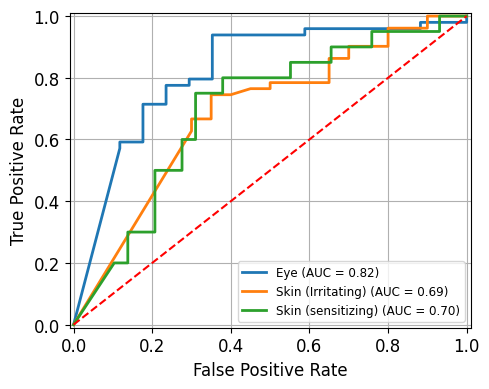

In [ ]:
# ============================================================================
# Use the best model to get predictions on the test dataset
# ============================================================================

best_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_pred_probs = torch.stack(test_outputs, dim=1)

# Create a single plot for all tasks' ROC curves
plt.figure(figsize=(5, 4))

accuracies = []

# Loop through each task to plot the ROC curves on the same panel
for task_idx in range(num_tasks):
    Y1_test_np = Y1_test.to_numpy()
    valid_mask = ~np.isnan(Y1_test_np[:, task_idx])  # Mask for valid labels
    valid_true_labels = Y1_test_np[valid_mask, task_idx]
    test_pred_probs_task = test_pred_probs[valid_mask, task_idx].numpy()

    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(valid_true_labels, test_pred_probs_task, pos_label=1)
    roc_auc = auc(fpr, tpr)
    print('--------------------------------------------------------------------')
    print('AUC for ' + task_names[task_idx] + ': ' + str(roc_auc))
    print('FPR for ' + task_names[task_idx] + ': ' + str(fpr))
    print('TPR for ' + task_names[task_idx] + ': ' + str(tpr))

    # Plot ROC curve for the current task
    plt.plot(fpr, tpr, lw=2, label=f'{task_names[task_idx]} (AUC = {roc_auc:.2f})')

    # Calculate accuracy for task
    predicted_labels = np.array([1.0 if output > 0.5 else 0.0 for output in test_pred_probs_task])

    # Print classification report
    #print("\nClassification Report:")
    #print(classification_report(valid_true_labels, predicted_labels))

    test_results = model_metrics(valid_true_labels, predicted_labels, test_pred_probs_task)

    print('--------------------------------------------------------------------')
    print("Overall Results for Test Set:")
    print("ROC-AUC, Balanced Accuracy, MCC, Accuracy, Precision, Recall, F1:")
    print(", ".join([f"{result:.3f}" for result in test_results]))

plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Plot the random classifier line

plt.xticks(np.arange(0, 1.1, 0.2), fontsize=12)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=12)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(True)
plt.legend(loc='lower right', fontsize=8.6)

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# Feature Importance Analysis: SHapley Additive exPlanation (SHAP) Plot Generation
# ============================================================================
num_features_to_show = 10

# Set global font size
plt.rcParams.update({'font.size': 20})

best_model.eval()

# Convert test tensors back to numpy
X_test_np = X_test_tensor.numpy()
Y_test_np = Y1_test_tensor.numpy()

feature_names = X_train_resampled.columns.tolist()

# Use a small sample to avoid heavy computation
X_sample = X_test_np[:500]

# Convert to torch tensor
X_sample_tensor = torch.tensor(X_sample, dtype=torch.float32)

# Define a prediction function compatible with SHAP
def model_predict(x_numpy):
    x_tensor = torch.tensor(x_numpy, dtype=torch.float32)
    with torch.no_grad():
        outputs = best_model(x_tensor)
        return [out.squeeze().numpy() for out in outputs]

explainer_list = []
shap_values_list = []

for task_idx, task_name in enumerate(task_names):
    def single_task_predict(x_numpy):
        probs = model_predict(x_numpy)
        return probs[task_idx]

    explainer = shap.Explainer(single_task_predict, X_sample, max_evals=2 * X_sample.shape[1] + 1)
    shap_values = explainer(X_sample)

    explainer_list.append(explainer)
    shap_values_list.append(shap_values)

    # Beeswarm plot
    fig_height = 0.6 * num_features_to_show + 1.5  # heuristic to keep bars wide

    plt.figure(figsize=(10, fig_height))
    shap.summary_plot(
        shap_values.values,
        X_sample,
        feature_names=feature_names,
        max_display=num_features_to_show,
        show=False,
    )
    plt.title(f"SHAP Beeswarm for {task_name}", fontsize=16)

    ax = plt.gca()
    ax.title.set_fontsize(16)
    ax.tick_params(axis='both', labelsize=20)

    plt.tight_layout()
    plt.show()

    # Bar plot
    fig_height = 0.6 * num_features_to_show + 1.5  # heuristic to keep bars wide

    plt.figure(figsize=(10, fig_height))  # Wider and taller figure
    shap.summary_plot(
        shap_values.values,
        X_sample,
        feature_names=feature_names,
        plot_type="bar",
        max_display=num_features_to_show,
        show=False,
    )
    ax = plt.gca()

    for patch in ax.patches:
        patch.set_facecolor("#888888")

    plt.title(f"SHAP Mean |Value| Bar Plot for {task_name}", fontsize=16)
    ax.title.set_fontsize(16)
    ax.tick_params(axis='both', labelsize=20)

    plt.tight_layout()
    plt.show()

In [ ]:
# ============================================================================
# (OPTIONAL): Print Important Features and as CSV file
# ===============================================================================
num_features_to_show = 20

for task_idx, task_name in enumerate(task_names):
    # Get shap values for this task
    shap_values_task = shap_values_list[task_idx].values

    # Compute mean absolute SHAP values per feature
    mean_abs_shap = np.abs(shap_values_task).mean(axis=0)

    # Get feature importance ranking
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'mean_abs_shap': mean_abs_shap
    })

    # Sort by importance
    feature_importance_df = feature_importance_df.sort_values(by='mean_abs_shap', ascending=False)

    # Take top N features
    top_features_df = feature_importance_df.head(num_features_to_show)[['feature']]

    # Save to CSV
    csv_filename = f"top_features_{task_name}.csv"
    top_features_df.to_csv(csv_filename, index=False)

    print(f"Saved top features for task '{task_name}' to: {csv_filename}")


In [ ]:
# ============================================================================
# Generate Applicability Domain Plot for Each Task
# ===============================================================================
def dropout_uncertainty(model, X, task_idx, num_samples=100):
    model.train()  # Set the model in train mode to keep dropout active
    predictions = []
    for _ in range(num_samples):
        output = model(X)[task_idx]
        predictions.append(output.detach().cpu().numpy())

    predictions = np.array(predictions)  # Shape: (num_samples, n_samples)
    mean_predictions = predictions.mean(axis=0)
    std_predictions = predictions.std(axis=0)
    return mean_predictions.squeeze(), std_predictions.squeeze()

n_samples = 50
epsilon = 1.5e-2

# Containers for predictions per task
mean_predictions_train = []
std_predictions_train = []
mean_predictions_test = []
std_predictions_test = []

for i in range(len(task_names)):
    mean_train, std_train = dropout_uncertainty(best_model, X_train_tensor, task_idx=i, num_samples=n_samples)
    mean_test, std_test = dropout_uncertainty(best_model, X_test_tensor, task_idx=i, num_samples=n_samples)

    mean_predictions_train.append(mean_train)
    std_predictions_train.append(std_train)
    mean_predictions_test.append(mean_test)
    std_predictions_test.append(std_test)

all_std_train = np.concatenate(std_predictions_train)
uncertainty_threshold = np.percentile(all_std_train, 95)  # 95th percentile threshold

X_train_np = X_train_resampled.values
X_test_np = X_test.values

# Robust scaling
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)


# PCA
pca = PCA(n_components=10)  # Choose appropriate number of components
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Compute train centroid
centroid = X_train_pca.mean(axis=0)

# Compute distances
distances_train = np.linalg.norm(X_train_pca - centroid, axis=1)
distances_test = np.linalg.norm(X_test_pca - centroid, axis=1)

# Close previous figures
plt.close('all')

fig, ax = plt.subplots(figsize=(8, 7))

colors = {'Train': 'blue', 'Test': 'orange'}
markers = {'Eye': 'o', 'Skin (Irritating)': 'v', 'Skin (sensitizing)': '+'}

for i, task_names in enumerate(task_names):
    y_true_train = Y1_train_tensor[:, i].numpy()
    mask_train = ~np.isnan(y_true_train)
    y_true_train = y_true_train[mask_train]
    y_predictions_train = np.clip(mean_predictions_train[i][mask_train], epsilon, 1 - epsilon)

    residuals_train = y_true_train - y_predictions_train
    pearson_train = residuals_train / np.sqrt(y_predictions_train * (1 - y_predictions_train))

    y_true_test = Y1_test_tensor[:, i].numpy()
    mask_test = ~np.isnan(y_true_test)
    y_true_test = y_true_test[mask_test]
    y_predictions_test = np.clip(mean_predictions_test[i][mask_test], epsilon, 1 - epsilon)

    residuals_test = y_true_test - y_predictions_test
    pearson_test = residuals_test / np.sqrt(y_predictions_test * (1 - y_predictions_test))

    ax.scatter(distances_train[mask_train], pearson_train, alpha=0.5,
               color=colors['Train'], marker=markers[task_names],
               label=f'{task_names} (Train)')

    ax.scatter(distances_test[mask_test], pearson_test, alpha=0.7,
               color=colors['Test'], marker=markers[task_names],
               label=f'{task_names} (Test)')


# Threshold lines
distance_threshold = distances_train.mean() + 3 * distances_train.std()
ax.axvline(distance_threshold, color='green', linestyle='--', linewidth=1)
ax.axhline(3, color='red', linestyle='--', linewidth=1)
ax.axhline(-3, color='red', linestyle='--', linewidth=1)

label_fontsize = 16
title_fontsize = 18
tick_fontsize = 14
legend_fontsize = 12

ax.set_xlabel('PCA Distance to Training Centroid', fontsize=label_fontsize)
ax.set_ylabel("Pearson's Residuals", fontsize=label_fontsize)
ax.set_title("Applicability Domain via PCA Distance", fontsize=title_fontsize)

ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

ax.legend(fontsize=legend_fontsize)
plt.tight_layout()
plt.show()

In [ ]:
# ============================================================================
# (OPTIONAL): Calculate % of Training/Test Within AD for Each Task
# ===============================================================================
print('--------------------------------------------------------------------')
print('Applicability Domain Coverage')
print('--------------------------------------------------------------------')

for i, task_names in enumerate(task_names):
    # Masks for valid samples
    y_true_train = Y1_train_tensor[:, i].numpy()
    mask_train = ~np.isnan(y_true_train)

    y_true_test = Y1_test_tensor[:, i].numpy()
    mask_test = ~np.isnan(y_true_test)

    # Compute distances
    distances_train_task = distances_train[mask_train]
    distances_test_task = distances_test[mask_test]

    # Get predicted probabilities
    y_predictions_train = np.clip(mean_predictions_train[i][mask_train], epsilon, 1 - epsilon)
    y_predictions_test = np.clip(mean_predictions_test[i][mask_test], epsilon, 1 - epsilon)

    # Residuals
    residuals_train = y_true_train[mask_train] - y_predictions_train
    pearson_train = residuals_train / np.sqrt(y_predictions_train * (1 - y_predictions_train))

    residuals_test = y_true_test[mask_test] - y_predictions_test
    pearson_test = residuals_test / np.sqrt(y_predictions_test * (1 - y_predictions_test))

    # Conditions for within AD
    within_ad_train = (distances_train_task <= distance_threshold) & (np.abs(pearson_train) <= 3)
    within_ad_test = (distances_test_task <= distance_threshold) & (np.abs(pearson_test) <= 3)

    # Calculate percentages
    percent_within_ad_train = 100.0 * np.sum(within_ad_train) / len(distances_train_task)
    percent_within_ad_test = 100.0 * np.sum(within_ad_test) / len(distances_test_task)

    # Print
    print('---------------------------------------------')
    print(f"Task: {task_names}")
    print(f"  Train samples within AD: {percent_within_ad_train:.2f}%")
    print(f"  Test samples within AD:  {percent_within_ad_test:.2f}%\n")


In [ ]:
# ============================================================================
# Visualize Confusion Matrices for Each Task
# ===============================================================================

def plot_confusion_matrix(Y_test, predicted_labels, task_names='Task'):
    cm = confusion_matrix(Y_test, predicted_labels)
    print('--------------------------------------------------------------------')
    print(f"Confusion Matrix for {task_names}:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'],
                annot_kws={"size": 16})

    plt.title(f"Confusion Matrix - {task_names}")
    plt.xlabel('Predicted',fontsize=20)
    plt.xticks(fontsize=18)
    plt.ylabel('True',fontsize=20)
    plt.yticks(fontsize=18)

    plt.tight_layout()
    plt.show()

threshold = 0.5

for i, task_names in enumerate(task_names):
    # True labels for test set
    y_true_test = Y1_test_tensor[:, i].numpy()
    mask_test = ~np.isnan(y_true_test)
    y_true_test_clean = y_true_test[mask_test].astype(int)

    # Predicted probabilities
    y_pred_probs = mean_predictions_test[i][mask_test]
    # Convert to binary labels
    y_pred_labels = (y_pred_probs >= threshold).astype(int)

    # Plot confusion matrix
    plot_confusion_matrix(y_true_test_clean, y_pred_labels, task_names=task_names)
